In [ ]:
# Libraries
import datetime as dt
import format_database as FORMATTHISDATABASE
import helper as HELPMEPLEASE
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm, t
from tqdm import tqdm

# Parameters and variables
XLS_PATH     = "Database.xlsx"
ROLLING_WINDOW = 252 
ASSETS  =  [
    'NATIONAL AUS.BANK - TOT RETURN IND',
    'ASX - TOT RETURN IND',
    'INSURANCE AUS.GROUP - TOT RETURN IND',
    'ORIGIN ENERGY (EX BORAL) - TOT RETURN IND',
    'WOODSIDE ENERGY GROUP - TOT RETURN IND',
    'APA GROUP - TOT RETURN IND',
    'SANTOS - TOT RETURN IND',
    'WASH.H SOUL PATSN.& CO. DFD. - TOT RETURN IND',
    'PRO MEDICUS - TOT RETURN IND',
    'CSL - TOT RETURN IND',
    'REA GROUP - TOT RETURN IND',
    'GOODMAN GROUP - TOT RETURN IND',
    'STOCKLAND STAPLED UNITS - TOT RETURN IND',
    'WOOLWORTHS GROUP - TOT RETURN IND',
    'WESFARMERS - TOT RETURN IND',
    'QANTAS AIRWAYS - TOT RETURN IND',
    'TECHNOLOGY ONE - TOT RETURN IND',
    'TELSTRA GROUP - TOT RETURN IND',
    'FORTESCUE - TOT RETURN IND',
    'RIO TINTO - TOT RETURN IND']



In [2]:
if "TotalReturnIndices" not in pd.ExcelFile(XLS_PATH).sheet_names:
    FORMATTHISDATABASE.create_TotalReturnIndices(
        excel_path    = XLS_PATH,
        chosen_assets = ASSETS
    )

RI_df = pd.read_excel(
    XLS_PATH, 
    sheet_name="TotalReturnIndices")

# Convert DATE to datetime (easier to handle)
RI_df["DATE"] = pd.to_datetime(RI_df["DATE"])
# Set DATE as index
RI_df.set_index("DATE", inplace=True)

# Calculate log-returns
returns_df = 100*np.log(RI_df / RI_df.shift(1)).dropna()

The whole point 2 is computed by a single function, see its description for more information (or take a peek at helper.py).

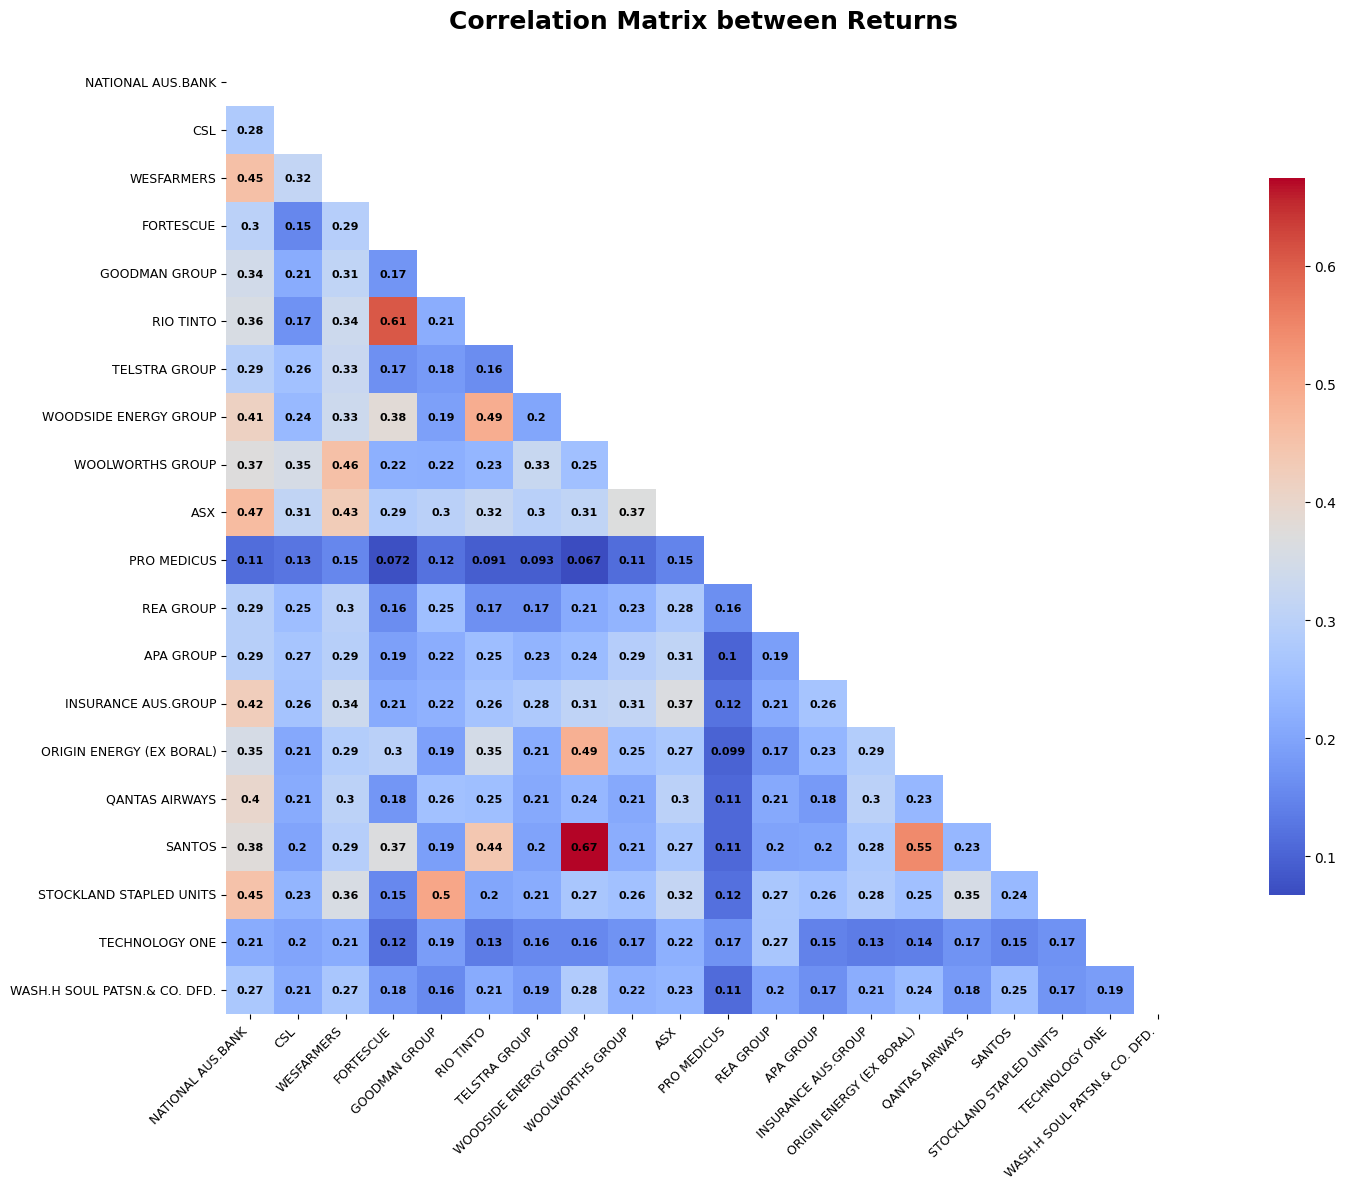

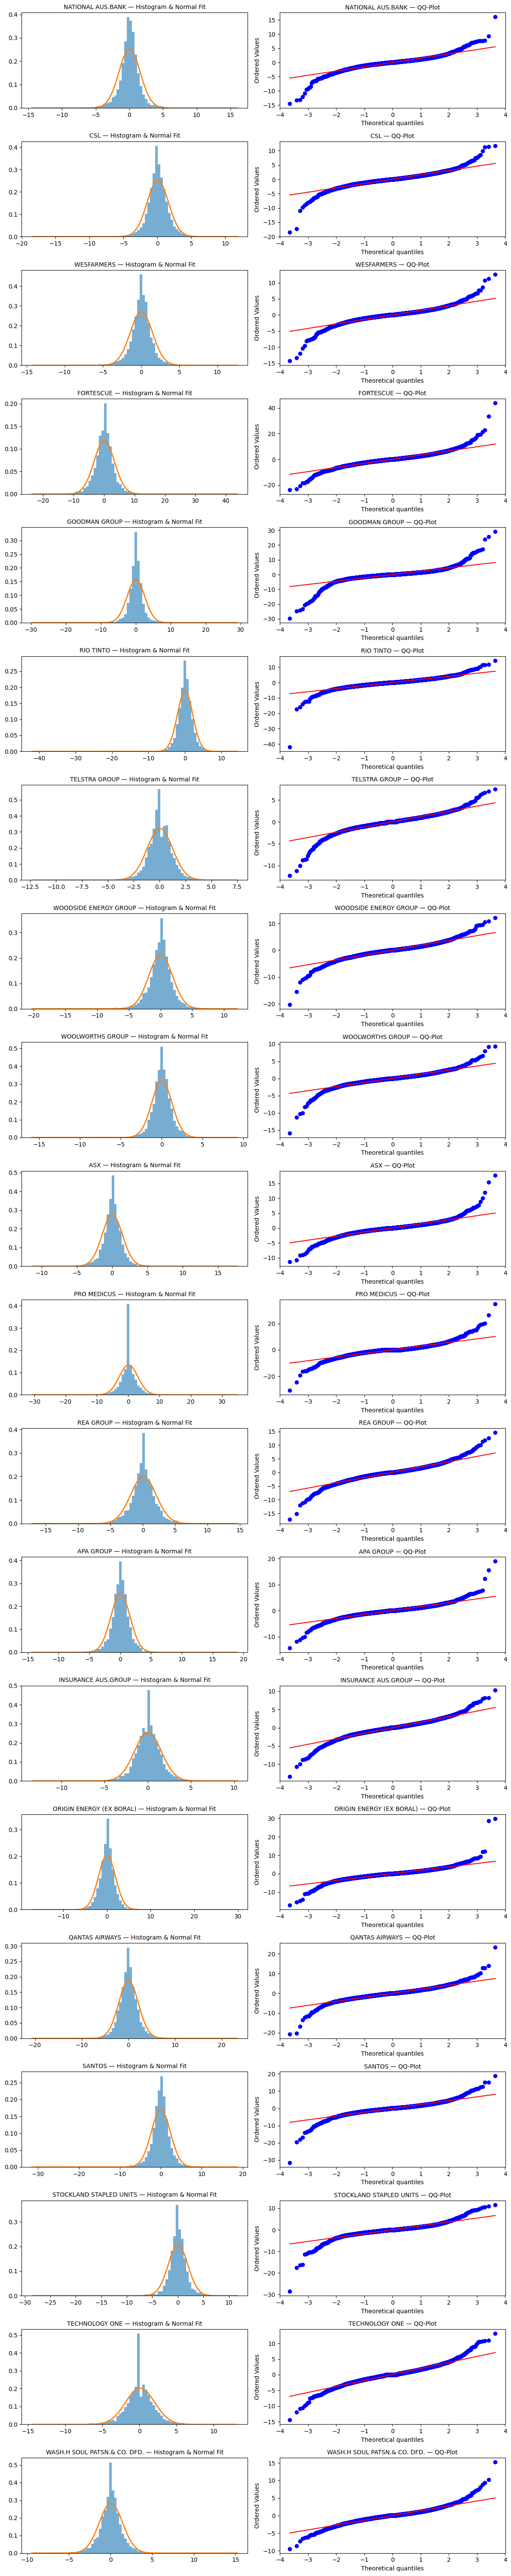

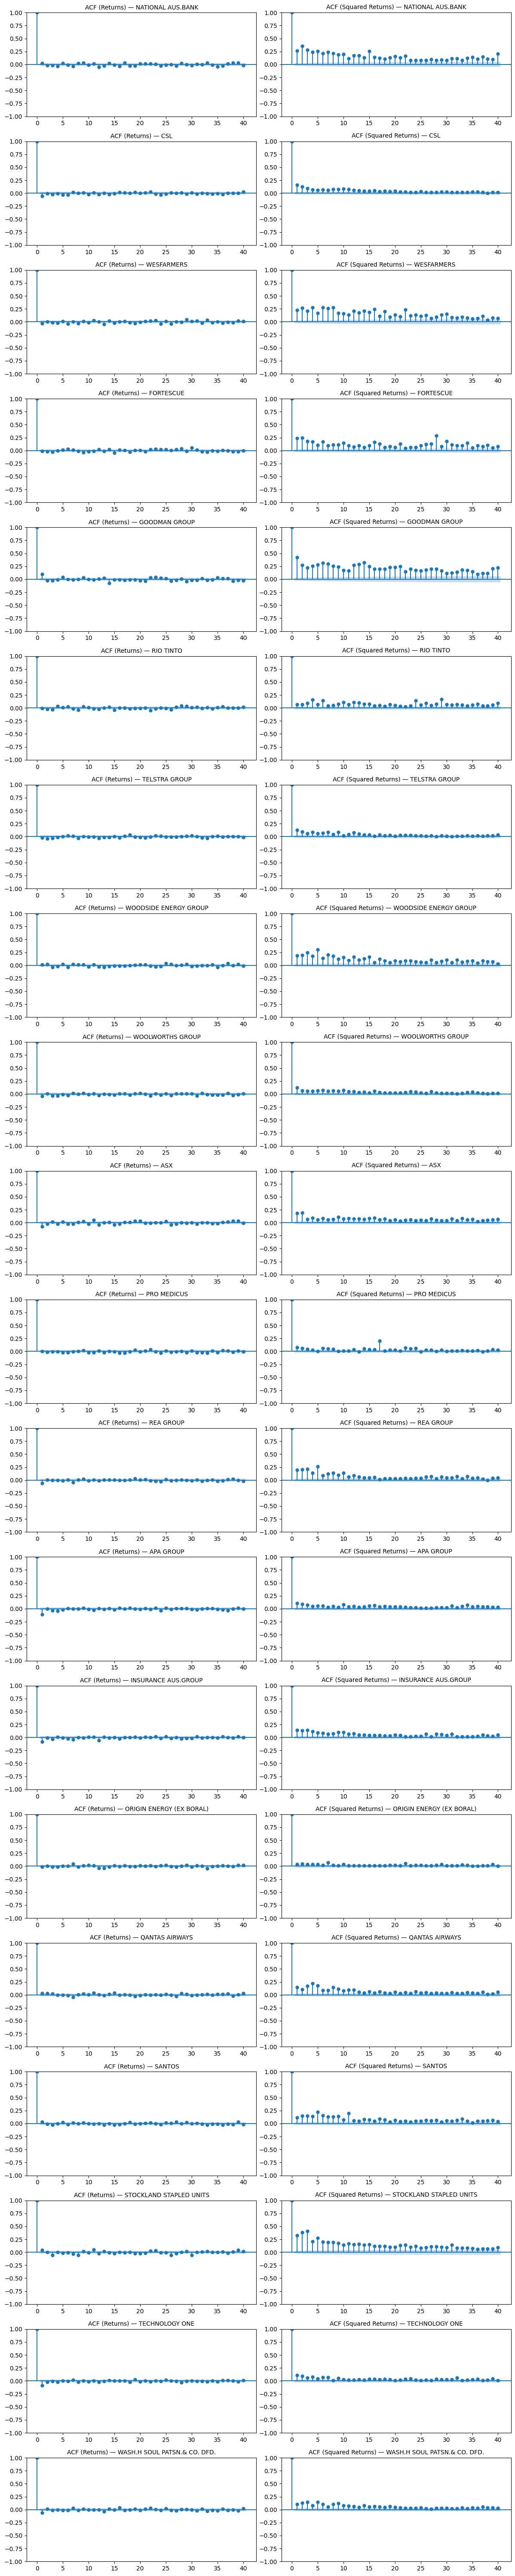

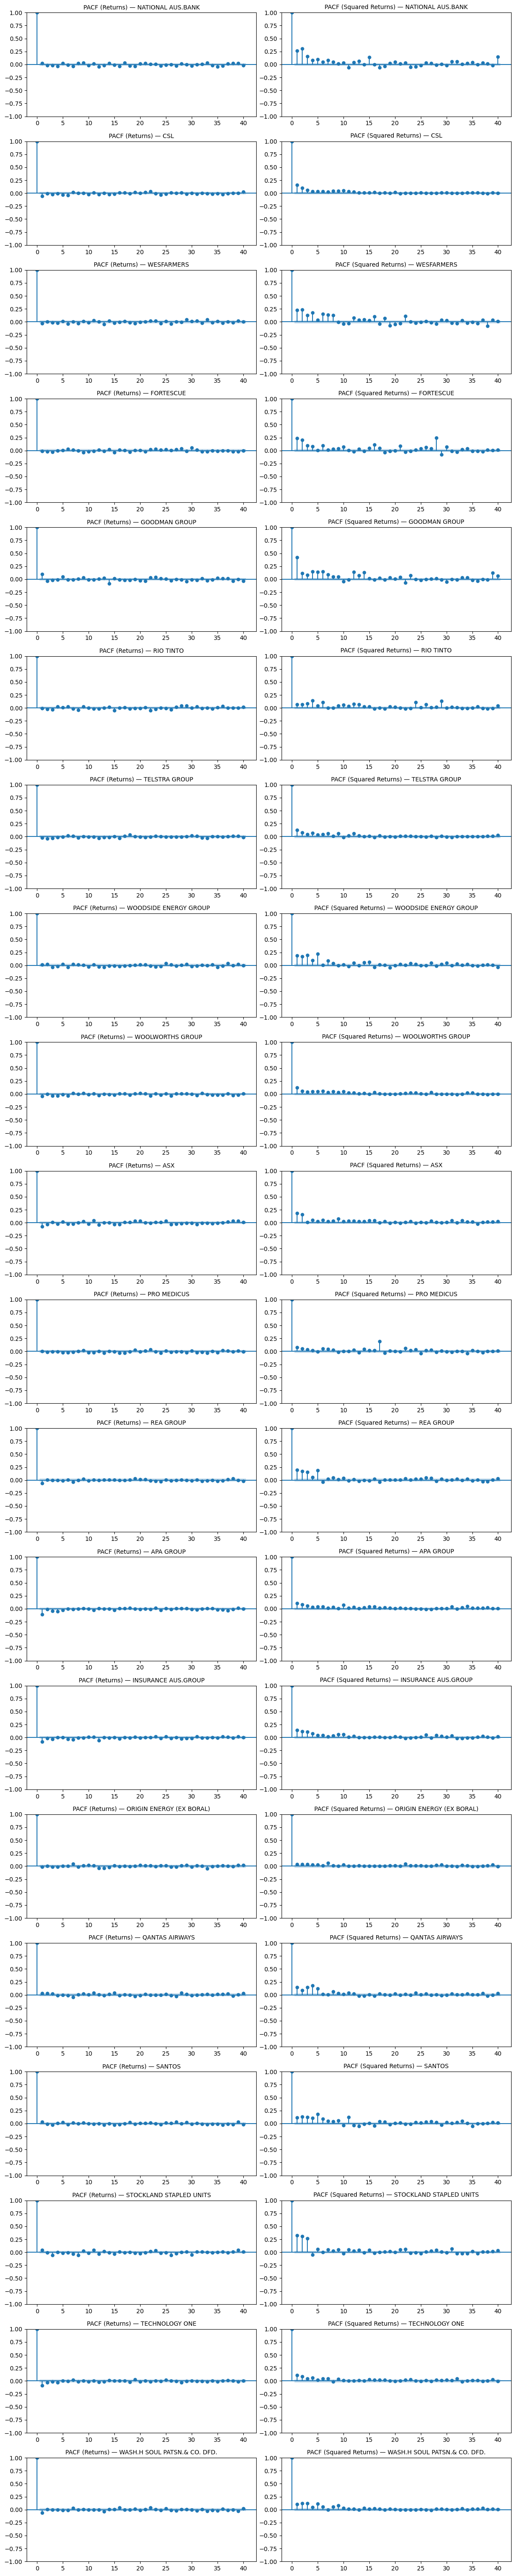

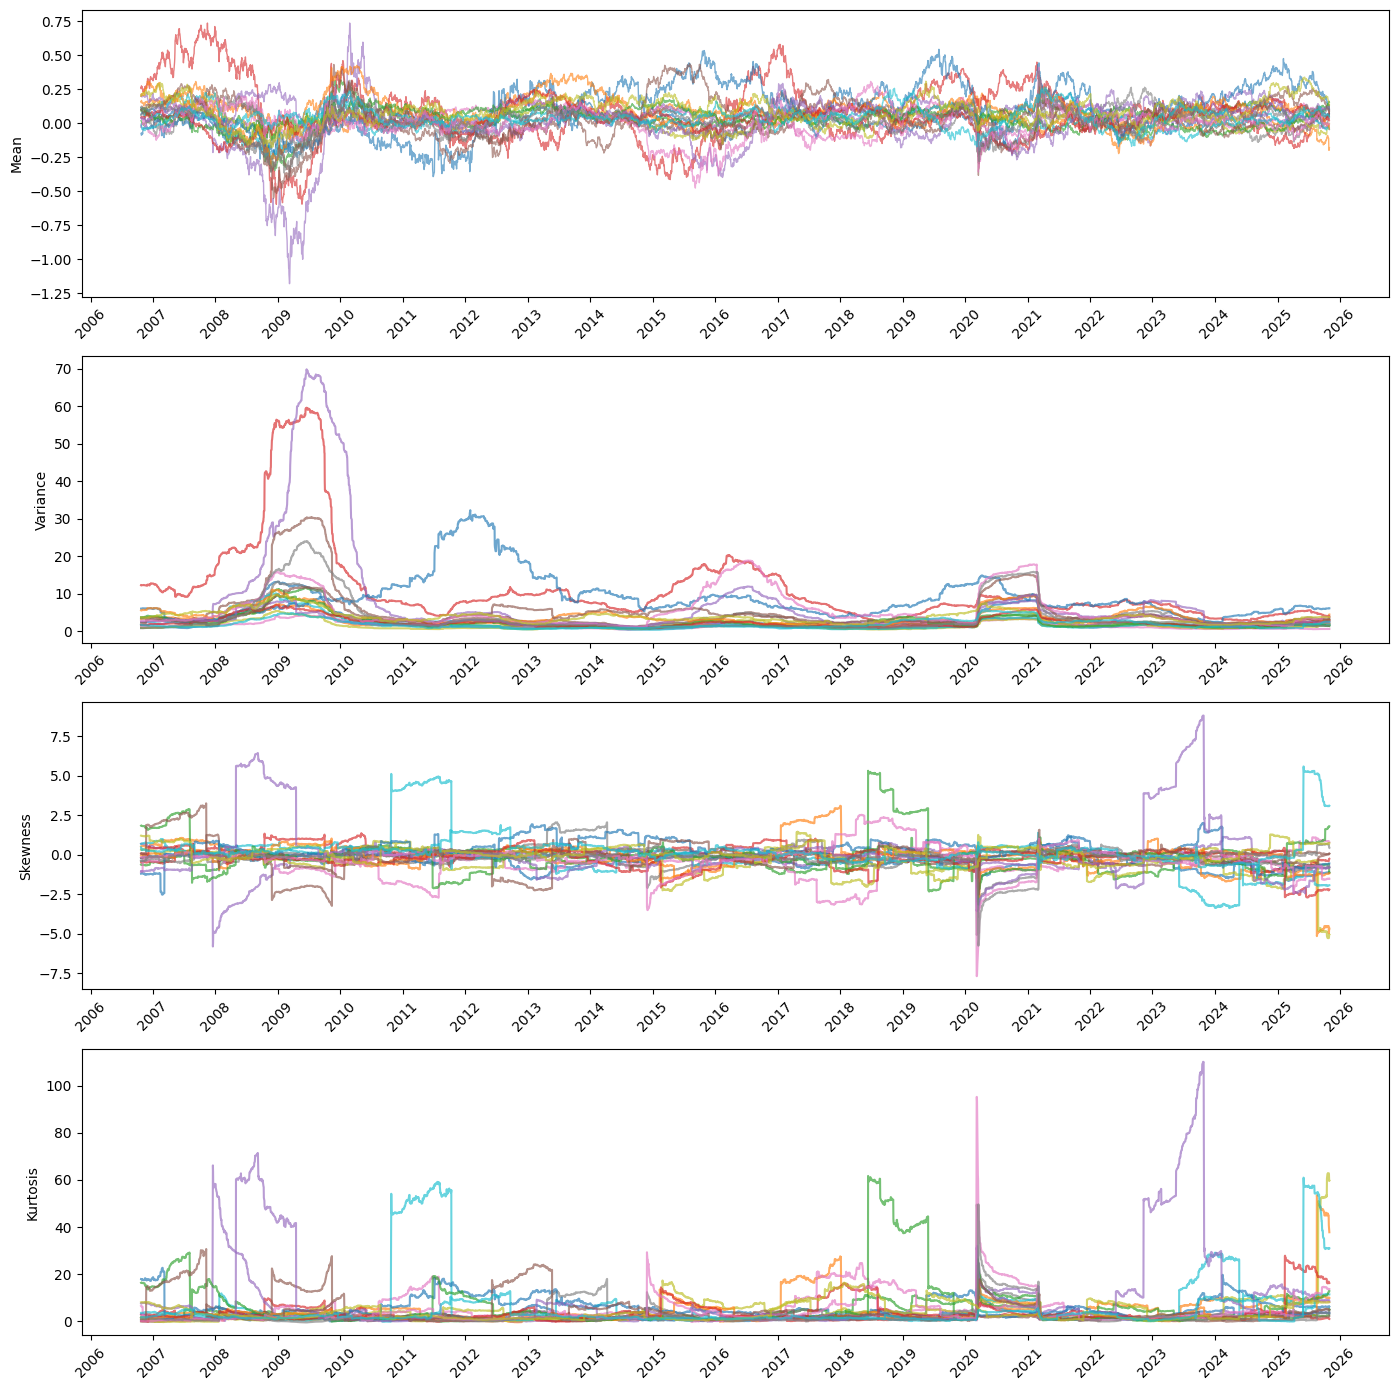

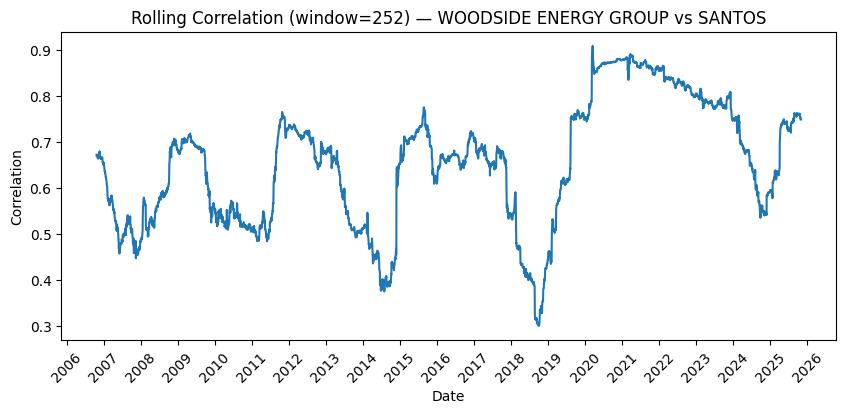

In [3]:
# Display descriptive statistics (more information in function description)
descriptive_stat_df = HELPMEPLEASE.visual_descriptive_statistics(returns_df, plot=False, save=False)

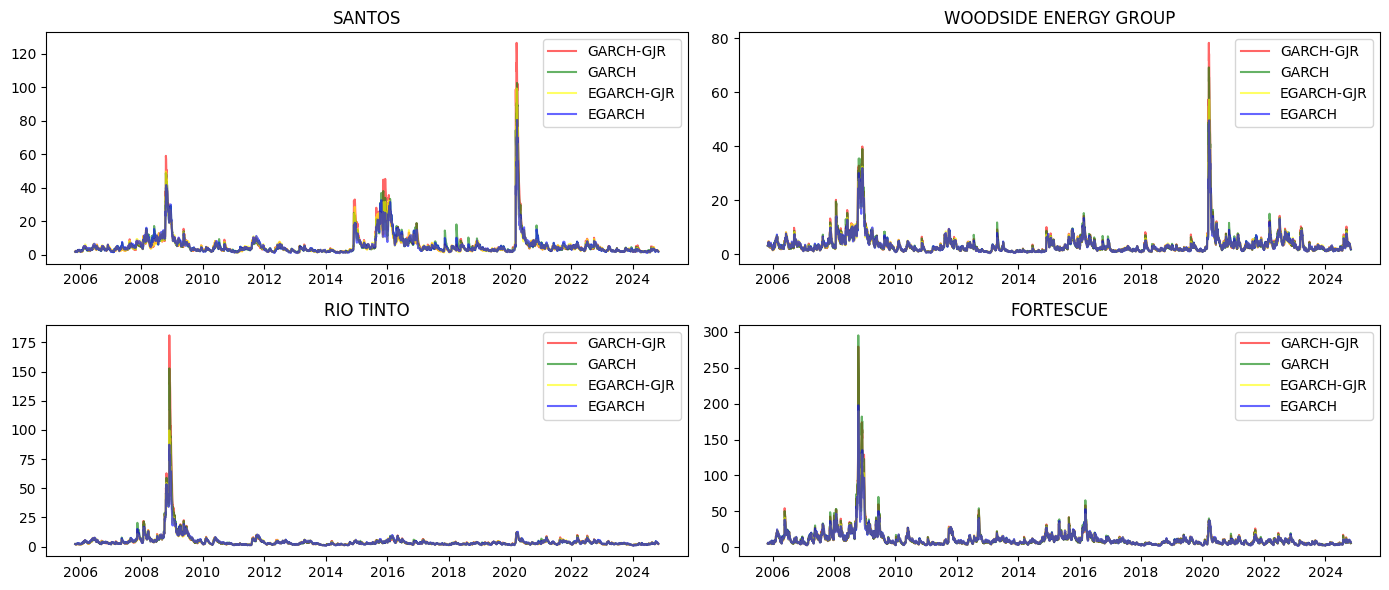

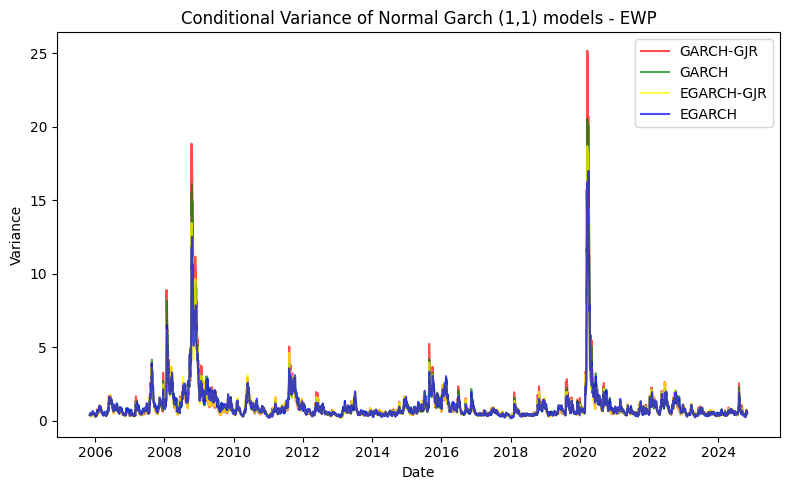

GARCH	AIC : 21199.88, BIC : 21225.91
GARCH-GJR	AIC : 21171.80, BIC : 21204.34
EGARCH	AIC : 21185.79, BIC : 21211.82
EGARCH-GJR	AIC : 21148.36, BIC : 21180.90
GARCH	AIC : 12728.37, BIC : 12754.40
GARCH-GJR	AIC : 12637.00, BIC : 12669.54
EGARCH	AIC : 12745.52, BIC : 12771.55
EGARCH-GJR	AIC : 12627.83, BIC : 12660.37


In [6]:
# Split sample (exclude last year)
cutoff_start = dt.datetime(2024, 11, 1)
cutoff_end   = dt.datetime(2025, 10, 31)
train = returns_df.loc[returns_df.index < cutoff_start]
test  = returns_df.loc[(returns_df.index >= cutoff_start) & (returns_df.index <= cutoff_end)]

# Calculate Equal-Weighted Portfolio returns
ewp = train.mean(axis=1)
# Focus analysis on the two pairs of assets with higher correlation
garch_diagnostics = HELPMEPLEASE.univariate_garch_diagnostics(train.filter(items=['SANTOS', 'WOODSIDE ENERGY GROUP', 'RIO TINTO', 'FORTESCUE']), plot=True, save=False)
ewp_garch_results = HELPMEPLEASE.ewp_garch_diagnostics(ewp)

for model in garch_diagnostics.keys():
    print(f"{model}\tAIC : {garch_diagnostics[model][0]:.2f}, BIC : {garch_diagnostics[model][1]:.2f}")
for model in ewp_garch_results.keys():
    print(f"{model}\tAIC : {ewp_garch_results[model][0]:.2f}, BIC : {ewp_garch_results[model][1]:.2f}")

In [ ]:
# ——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————— #
# Config
WINDOW = 1000                 # rolling window length (set None to use expanding window)
ALPHA = 0.05                  # VaR confidence level
MODEL_FOR_SIGMA = "EGARCH"    # "GARCH" or "EGARCH"
DIST_FOR_SIGMA = "normal"     # distribution used to estimate sigma (normal is fine)
ASSET_NAMES = list(train.columns)
TEST_DATES = test.index
UNIVARIATE_GARCH_MODELS = ["GARCH", "GARCH-GJR", "EGARCH", "EGARCH-GJR"]

# ————————————————————————————————————————————————————
# 1) Rolling forecasts per asset
print("Rolling one-step-ahead forecasts (per asset)…")
mu_forecasts  = pd.DataFrame(index=TEST_DATES, columns=ASSET_NAMES, dtype=float)
var_forecasts = pd.DataFrame(index=TEST_DATES, columns=ASSET_NAMES, dtype=float)

for asset in tqdm(ASSET_NAMES, desc="Rolling forecasts", 
                  unit="asset", ncols=100, colour='green'): 
    mu_f, var_f = HELPMEPLEASE.rolling_forecast_sigma(
    train[asset], test[asset],
    model_name=MODEL_FOR_SIGMA, dist=DIST_FOR_SIGMA, window=WINDOW
    )
    mu_forecasts[asset]  = mu_f
    var_forecasts[asset] = var_f

# ————————————————————————————————————————————————————
# 2) Rolling forecasts for Equal-Weighted Portfolio
ewp_full  = returns_df.mean(axis=1)
ewp_train = ewp_full.loc[ewp_full.index < cutoff_start]
ewp_test  = ewp_full.loc[(ewp_full.index >= cutoff_start) & (ewp_full.index <= cutoff_end)]

mu_ewp, var_ewp = HELPMEPLEASE.rolling_forecast_sigma(
    ewp_train, ewp_test,
    model_name=MODEL_FOR_SIGMA, dist=DIST_FOR_SIGMA, window=WINDOW
)

# ————————————————————————————————————————————————————
# 3) Fit residual distributions (Normal vs Student-t)
fit_info = {a: HELPMEPLEASE.fit_residual_distribution(train[a], model_name=MODEL_FOR_SIGMA, dist_for_fit="normal")
            for a in ASSET_NAMES}
fit_info["EWP"] = HELPMEPLEASE.fit_residual_distribution(ewp_train, model_name=MODEL_FOR_SIGMA, dist_for_fit="normal")

# ————————————————————————————————————————————————————
# 4) Compute VaR forecasts
var_results = {}

var_results[f"VaR_normal_{ALPHA}"] = HELPMEPLEASE.compute_VaR(mu_forecasts, var_forecasts, ALPHA, distribution="normal")
var_results[f"VaR_t_{ALPHA}"] = HELPMEPLEASE.compute_VaR(
 mu_forecasts, var_forecasts, ALPHA, distribution="student-t",
     df_param={a: fit_info[a]['df_t'] for a in ASSET_NAMES}
 )
# EWP
var_results[f"VaR_normal_ewp_{ALPHA}"] = HELPMEPLEASE.compute_VaR(mu_ewp, var_ewp, ALPHA, distribution="normal")
var_results[f"VaR_t_ewp_{ALPHA}"] = HELPMEPLEASE.compute_VaR(
    mu_ewp, var_ewp, ALPHA, distribution="student-t", df_param=fit_info["EWP"]["df_t"]
)

# ————————————————————————————————————————————————————
# 5) Summary statistics
summary = pd.DataFrame({
    "VaR_normal_mean": var_results[f"VaR_normal_{ALPHA}"].mean(),
    "VaR_t_mean":      var_results[f"VaR_t_{ALPHA}"].mean(),
    "difference":      var_results[f"VaR_t_{ALPHA}"].mean() - var_results[f"VaR_normal_{ALPHA}"].mean(),
    "ks_p_norm":       [fit_info[a]["ks_norm_p"] for a in ASSET_NAMES],
    "ks_p_t":          [fit_info[a]["ks_t_p"] for a in ASSET_NAMES],
    "df_t":            [fit_info[a]["df_t"]     for a in ASSET_NAMES],
}, index=ASSET_NAMES)

print("\n" + "—"*60)
print("SUMMARY STATISTICS (per asset)")
display(summary.round(5))
df_mean = summary["df_t"].mean()
print(f"\nAverage degrees of freedom (t): {df_mean:.2f}")
print(f"Normal quantile at α={ALPHA}: {norm.ppf(ALPHA):.3f}")
print(f"Student-t quantile at α={ALPHA}: {t.ppf(ALPHA, df_mean):.3f}")

# ————————————————————————————————————————————————————
# 6) Visualizations
example_asset = ASSET_NAMES[0]

HELPMEPLEASE.plot_var(
    TEST_DATES,
    test[example_asset],
    var_results[f"VaR_normal_{ALPHA}"][example_asset],
    var_results[f"VaR_t_{ALPHA}"][example_asset],
    f"{example_asset} — VaR {int((1-ALPHA)*100)}%",
    ALPHA
)

HELPMEPLEASE.plot_var(
    TEST_DATES,
    ewp_test,
    var_results[f"VaR_normal_ewp_{ALPHA}"],
    var_results[f"VaR_t_ewp_{ALPHA}"],
    f"EWP — VaR {int((1-ALPHA)*100)}%",
    ALPHA
)


Rolling one-step-ahead forecasts (per asset)…


Rolling forecasts:   0%|                                                  | 0/20 [00:00<?, ?asset/s]

Rolling forecasts:  80%|████████████████████████████████▊        | 16/20 [01:48<00:34,  8.56s/asset]